Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "chapters", "03")
cd(ProjDir)

Define the Stan language model

In [3]:
binomialstanmodel = "
// Inferring a Rate
data {
  int N;
  int<lower=0> k[N];
  int<lower=1> n[N];
}
parameters {
  real<lower=0,upper=1> theta;
  real<lower=0,upper=1> thetaprior;
}
model {
  // Prior Distribution for Rate Theta
  theta ~ beta(1, 1);
  thetaprior ~ beta(1, 1);

  // Observed Counts
  k ~ binomial(n, theta);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [4]:
stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
  output_format=:mcmcchain);
# Use 16 observations
N2 = 4
n2 = Int.(9 * ones(Int, N2))
k2 = [6, 5, 7, 6]

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/03



4-element Array{Int64,1}:
 6
 5
 7
 6

Input data for cmdstan

In [5]:
binomialdata = [
  Dict("N" => length(n2), "n" => n2, "k" => k2)
];

Sample using cmdstan

In [6]:
rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)


make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/03/tmp/binomial' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Calling /Users/rob/Projects/StanSupport/cmdstan/bin/stansummary to infer across chains.

Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.027, 0.025, 0.025, 0.026) seconds, 0.10 seconds total
Sampling took (0.044, 0.051, 0.044, 0.045) seconds, 0.18 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -27  2.6e-02     1.1    -29   -27   -26  1.7e+03  9.2e+03  1.0e+00
accept_stat__   0.92  1.5e-03    0.11   0.69  0.96   1.0  4.9e+03  2.7e+04  1.0e+00
stepsize__      0.84  3.6e-02   0.050   0.77  0.86  0.90  2.0e+00  1.1e+01  3.5e+13
treedepth__      2.1  2.9e-02    0.73    1.0   2.0   3.0  6.5e+02  3.5e+03  1.0e+00
n_leapfrog__   

Look at area of hpd

In [7]:
MCMCChain.hpd(chn)

      95% Lower 95% Upper
theta  0.514455  0.803694



Plot the 4 chains

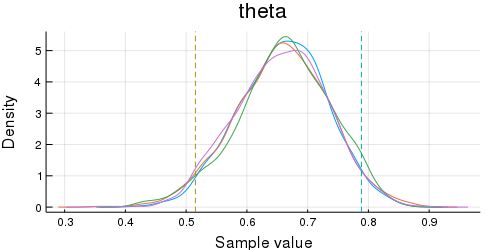

In [8]:
if rc == 0
  mixeddensity(chn, xlab="height [cm]", ylab="density")
  bnds = MCMCChain.hpd(convert(Vector{Float64}, chn.value[:,1,1]))
  vline!([bnds[1]], line=:dash)
  vline!([bnds[2]], line=:dash)
end

End of `clip_06_16s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*